<a href="https://colab.research.google.com/github/dungwoong/NN/blob/main/Variational_AE_and_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1H4MzhkchmZyfxqB_x-JIVS_szoA_JUij?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

Code taken from [handson-ml2](https://github.com/ageron/handson-ml2)

In [20]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
# keras has a backend global session with some utilities and stuff
# this is how it knows to name your things dense_x or whatever, and remembers the order and shit.
K = keras.backend

In [7]:
# load data - don't worry about it
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


# Variational Autoencoder(VAE)

## Creating and Training the VAE

In [4]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        # tf.shape returns a tensor the same dimensions as log_var
        # so the next line of code
        #  - creates a tensor same size as log_var(log vars of all the features or whatever) filled with std normal RV
        #  - multiplies by the e^(logvar/2) --> gets stddev I think
        #  - adds mean. Basically just adjusts the z-score back to the regular shit.
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [6]:
tf.random.set_seed(42)
np.random.seed(42)
codings_size = 10

In [8]:
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

Input --> Flatten --> Dense(150) --> Dense(100) --> mean + logvar layers --> inputted to a sampling layer.

So basically the variational encoder is like a normal encoder but at the end it branches into mean and log variance layers, and comes back to a sampling layer. This is pretty standard(cuz that's literally what a variational AE is)

Mean/Logvar codings are just dense layers that are both size 10. Honestly I think they're just separated so the sampling function can work, and so that he can keep track of them

He also keeps track of the mean, logvar outputs by putting them in the list of outputs(making them auxiliary outputs)

In [9]:
variational_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 150)          117750      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          15100       ['dense[0][0]']                  
                                                                                              

In [10]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

inputs(size is 10 I think) BECAUSE CODINGS is 10 pairs of mean, log var. That's why he uses log_var's shape. He just needs 10 basically.

Anyways, inputs --> dense --> dense --> dense --> reshape. That's literally it.

In [11]:
_, _, codings = variational_encoder(inputs) # he just gets the codings layer
reconstructions = variational_decoder(codings) # get the reconstructions
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
# final model input is the encoder's inputs, outputs is the reconstructions.
# I guess from the functional api when you call something it returns the output layer or whatever. Makes sense.
# he just connects the things together and that's it.

In [12]:
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

Losses:

First loss is just crossentropy, which forces the autoencoder to reproduce its inputs.

Second is latent loss. Pushes AE to have codings that look like they were sampled from a simple gaussian distribution.

Kullback-Liebler divergence between the target distribution(gaussian, in this case) and the actual distribution of the codings.

Ok basically your encoder will output a set of means/SD. You commonly tweak this formula by having your encoder output log(var) instead of SD. You then use the formula used in the code. This is more stable and speeds up training, that's all. Your sampling layer is inside the encoder because later you can sample/plug shit in, and then plug that straight into the decoder.

$$-0.5 * \sum(1+ln(var) - var - mean^2)$$

This is just the formula for latent loss I guess, we add that loss(mean + divided by 784 to scale it to compare with reconstruction loss)

In [14]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))
    # basically just round the outputs(0-1 cuz we scaled down) and get accuracy
    # its like...idk it's just a metric lol

In [15]:
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

add_loss() doesn't depend on the y_true and y_pred. You can write super complex and unique loss functions, that are usually model-dependent. Specifying a loss in the compile does some sort of computation with y_true and y_pred.

Pretty sure when you add multiple losses, it tries to minimize the sum of them, or the average, or whatever(unless if you put in weights for the losses)

In [16]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 8s 7ms/step - loss: 0.4098 - rounded_accuracy: 0.8502 - val_loss: 0.3684 - val_rounded_accuracy: 0.8868
Epoch 2/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3574 - rounded_accuracy: 0.8906 - val_loss: 0.3587 - val_rounded_accuracy: 0.8859
Epoch 3/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3479 - rounded_accuracy: 0.8978 - val_loss: 0.3513 - val_rounded_accuracy: 0.8936
Epoch 4/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3430 - rounded_accuracy: 0.9017 - val_loss: 0.3455 - val_rounded_accuracy: 0.9030
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3399 - rounded_accuracy: 0.9040 - val_loss: 0.3427 - val_rounded_accuracy: 0.9045
Epoch 6/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3377 - rounded_accuracy: 0.9060 - val_loss: 0.3358 - val_rounded_accuracy: 0.9085
Epoch 7/25
430/430 [==============================] 

## Plotting Some Sample Images with the VAE

In [23]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 3, 6))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

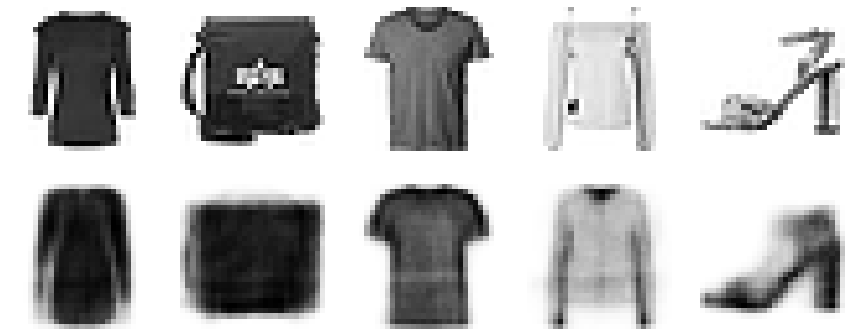

In [24]:
show_reconstructions(variational_ae)
plt.show()

## Generating Fashion Images with the VAE

In [61]:
def plot_multiple_images(images, n_cols=None, scale_factor=1):
    n_cols = n_cols or len(images) # if n_cols is None then =len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1: # probably if there's batches, remove batch list to just get a list of obs
        images = np.squeeze(images, axis=-1) # removes axes of length 1 from images
    plt.figure(figsize=(n_cols*scale_factor, n_rows*scale_factor))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

all we do to generate images is take form the standard normal distribution, run these codings thru the decoder and plot the images

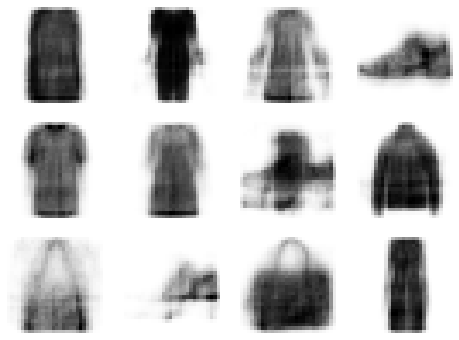

In [42]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

Semantic interpolation: instead of interpolating two images at the pixel level, we can interpolate at a codings level. 

Basically, interpolation is like when you have known values and you estimate an unknown by using those.

Eg. frame interpolation in animation is when you take two frames, and you generate an intermediate frame that tries to connect those two.

Here, if we interpolated like that at a pixel level, it would look like two images were overlaid on top of each other

Instead, we interpolate at a codings level. We encode both images, interpolate the codings we get, and finally decode the interpolated codings to get the final image. It will intermediate between two images.

HOW TO DO THIS:
 - we organize the 12 codings we generated to 3x4
 - we use tf.image.resize() to resize the grid to 5x7. By default, this performs bilinear interpolation, so every other row/col will contain interpolated codings. Then we produce all images using the decoder.

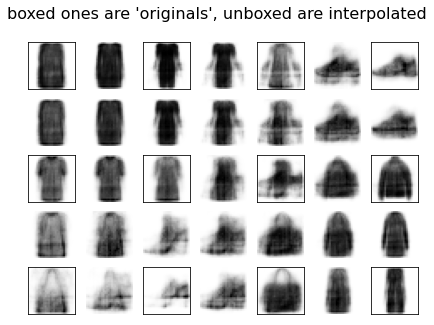

In [43]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7]) # larger grid, we resize to 5x7 (pretend it's an image, so actual size is 5x7xchannels[10 I think])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size]) # resize back into previous format so we can feed into decoder
images = variational_decoder.predict(interpolated_codings) # we just decode it lol
# you can also images = variational_decoder(interpolated_codings). Equivalent statement, less text.

fig = plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

fig.suptitle("boxed ones are 'originals', unboxed are interpolated", fontsize=16)
plt.show()

not very good. Pretty blurry and stuff. However, VAE generates quite blurry images, and it didn't have much time to train. The architecture is also quite simple(just a dense network).

# Let's try training a GAN

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

Generator is just a dense network that takes codings in and outputs 28x28, discriminator is just a classification model that then outputs 0 or 1(whether or not image was made by generator)

In [51]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [52]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [62]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50, show_images=True):
    generator, discriminator = gan.layers # gan just has 2 layers so ye
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs)) # just types the epoch number
        for X_batch in dataset:
            # phase 1 - training the discriminator

            # generate from random normal distribution and make the generator make images
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            # concatenate fake and real images together
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            # generate labels(0 for generated, 1 for real)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # make discriminator trainable and train it on the batch
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # note you don't have to set generators layers to trainable=False because you do not ever backpropagate thru them here.
            
            # phase 2 - training the generator
            # generate random sample again
            noise = tf.random.normal(shape=[batch_size, codings_size])

            # get ys, discriminator should predict 0 for all of these, but we want it to predict 1, so we set that as the label
            # discriminator not trainable in this stage, so we're teaching the generator to fool it.
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False

            # so then here, we're training the generator to produce better images(to try to fool the discrimiinator)
            gan.train_on_batch(noise, y2)

        # plot a few images generated after the epoch to look at improvement(4fun)
        if show_images:
          plot_multiple_images(generated_images, 8)
          plt.show()

Epoch 1/1


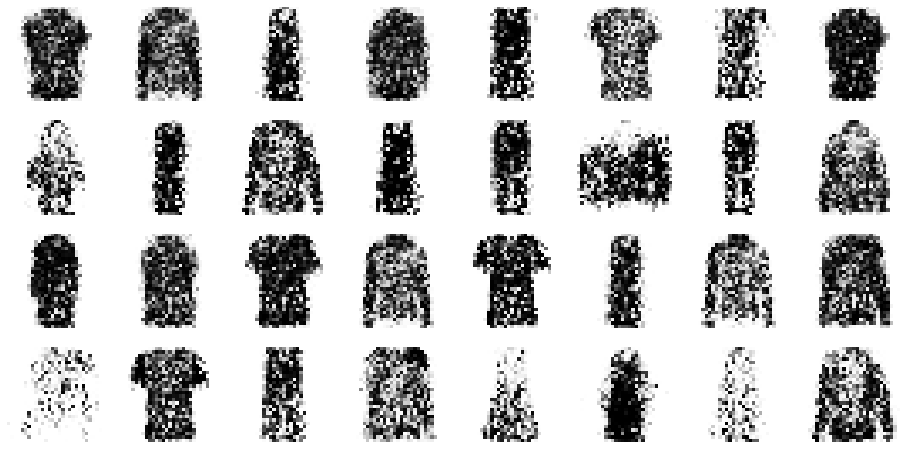

In [54]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [55]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=9, show_images=False)

Epoch 1/9
Epoch 2/9
Epoch 3/9
Epoch 4/9
Epoch 5/9
Epoch 6/9
Epoch 7/9
Epoch 8/9
Epoch 9/9


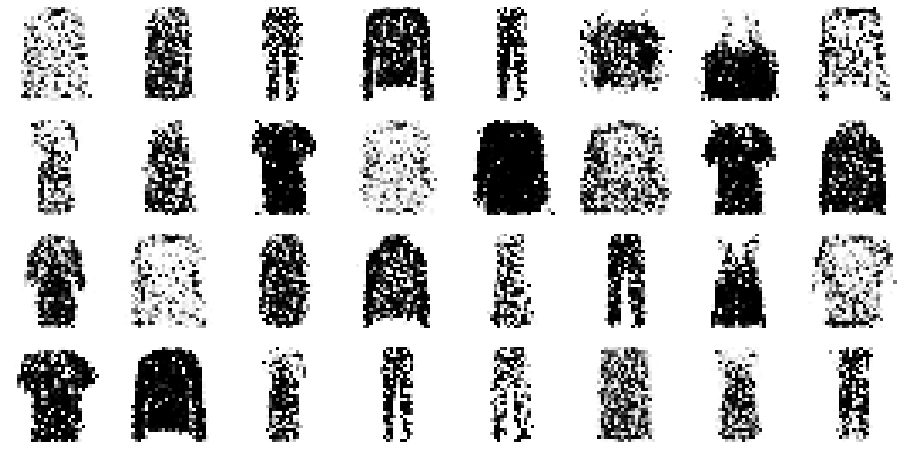

In [56]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

images are definitely more crisp, although they have a bunch of holes lol.

Training for more epochs would probably solve this, but since the GAN is super basic, I won't do that. We will move on.

Imagine if we put this together with a denoising AE or something...wouldn't that be CRISP?!?!

notice at this point we straight up don't know what the encodings are...we could build an encoder and train it and freeze the generator's layers to try to figure out the encodings, but what's the point at this timme.

# Deep Convolutional GAN

remember, conv2dTranspose basically just reverses conv2d kinda

So in a research paper proposing Deep Convolutional GANs(DCGANs), a few guidelines were proposed for building stable convolutional GANs:

- replace pooling with strided convolutions and transposed convs in generator and disc, respectively
- use batch normalization in the generator and discriminator, except in output/input layers
- use fully connected hidden layers for deep architectures
- use relu in the generator for all layers except for output layer. Tanh for output layer
- use leaky relu in the discriminator for all layers.

Works in many cases, so we'll follow them

In [57]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

Takes codings of size 100, projects them to 7x7x128 dimensions and reshapes the result to get a 7x7x128 tensor. Tensor gets pooled down kinda idk the term using the strided conv2d. It upsamples the image size but reduced the depth. Eventually we get 28x28x1.

Since we use Tanh, we produce outputs from -1 to 1. We have to rescale the training set to the same range, and reshape to add channel dimension so it's like
list of [28x28x1] tensors

In [58]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [59]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [60]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [63]:
gan.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 28, 28, 1)         840705    
                                                                 
 sequential_7 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


Epoch 1/30


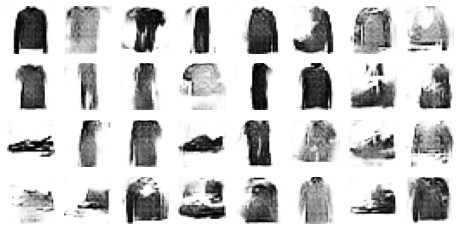

Epoch 2/30


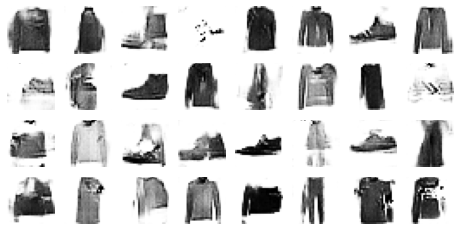

Epoch 3/30


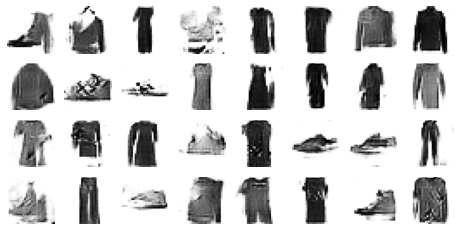

Epoch 4/30


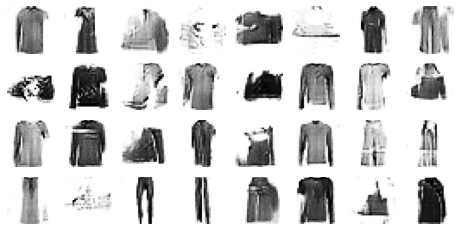

Epoch 5/30


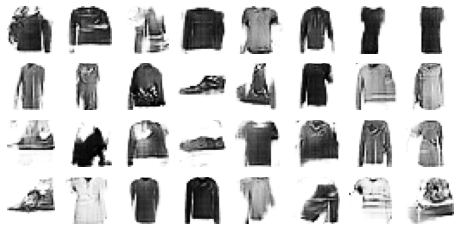

Epoch 6/30


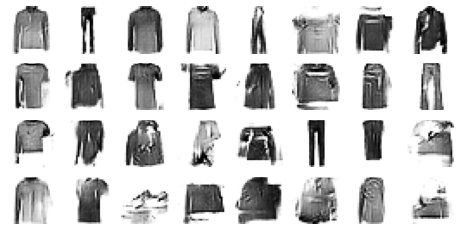

Epoch 7/30


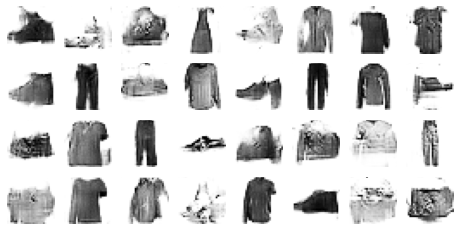

Epoch 8/30


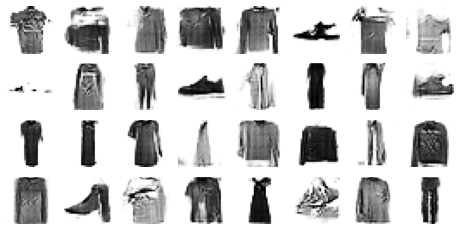

Epoch 9/30


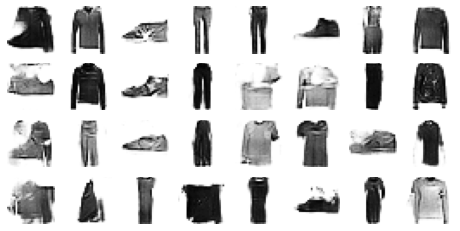

Epoch 10/30


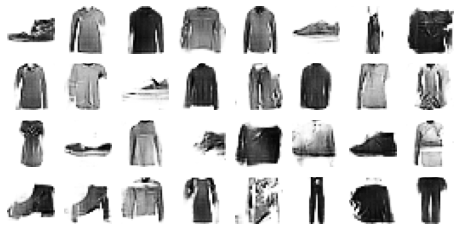

Epoch 11/30


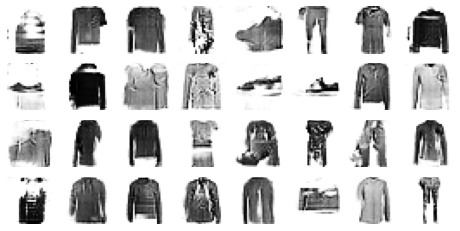

Epoch 12/30


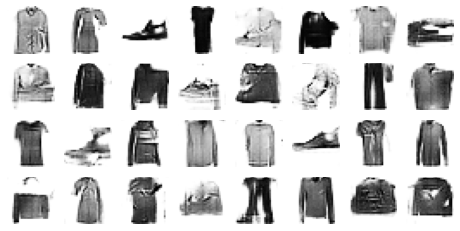

Epoch 13/30


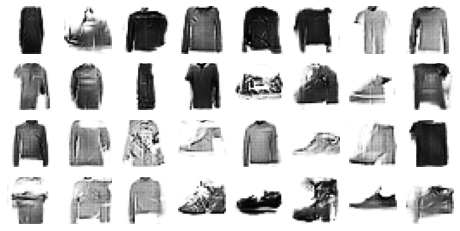

Epoch 14/30


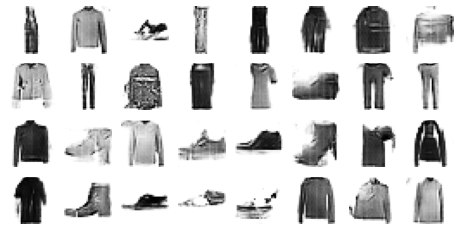

Epoch 15/30


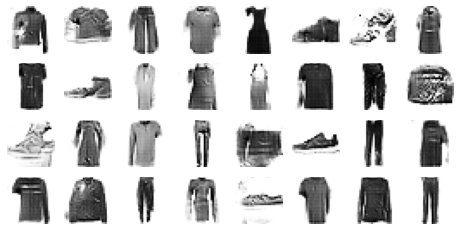

Epoch 16/30


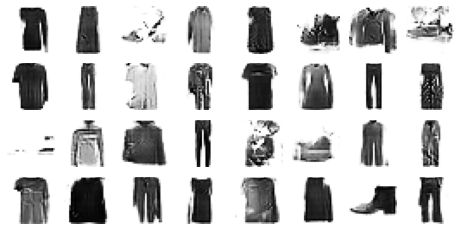

Epoch 17/30


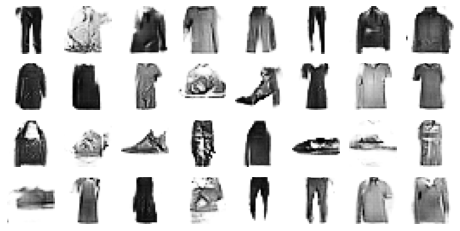

Epoch 18/30


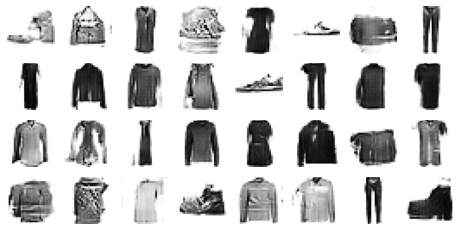

Epoch 19/30


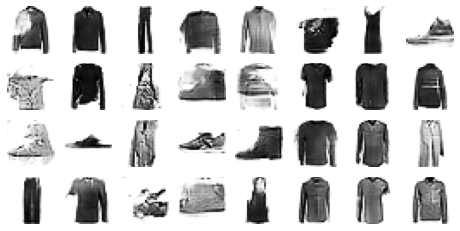

Epoch 20/30


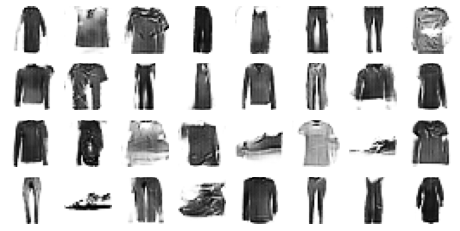

Epoch 21/30


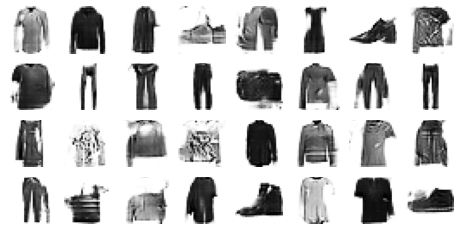

Epoch 22/30


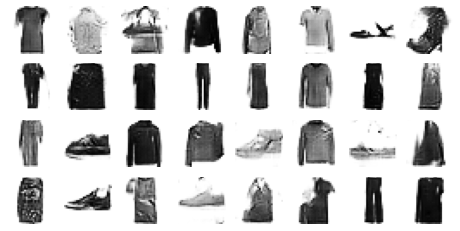

Epoch 23/30


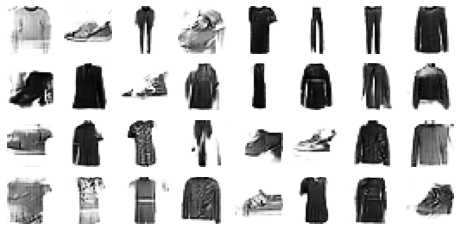

Epoch 24/30


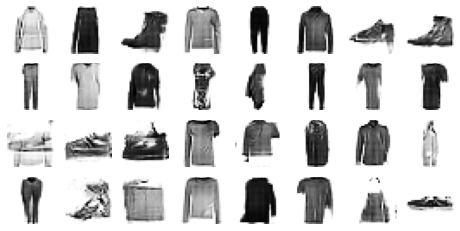

Epoch 25/30


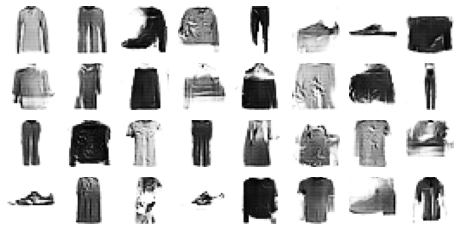

Epoch 26/30


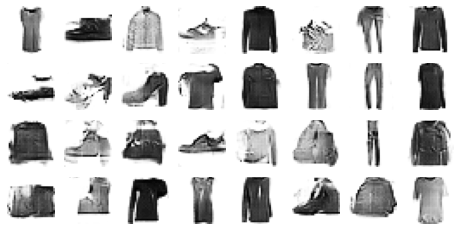

Epoch 27/30


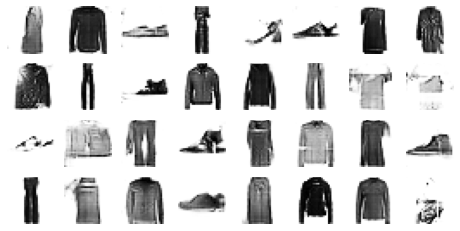

Epoch 28/30


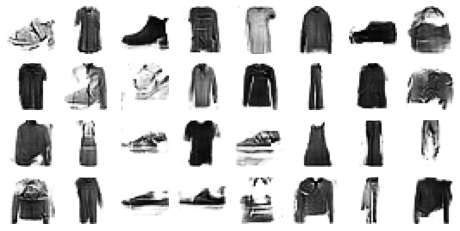

Epoch 29/30


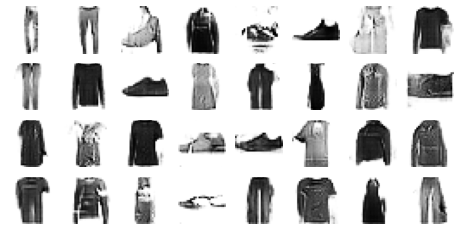

Epoch 30/30


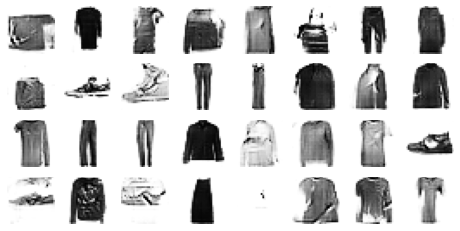

In [64]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=30)

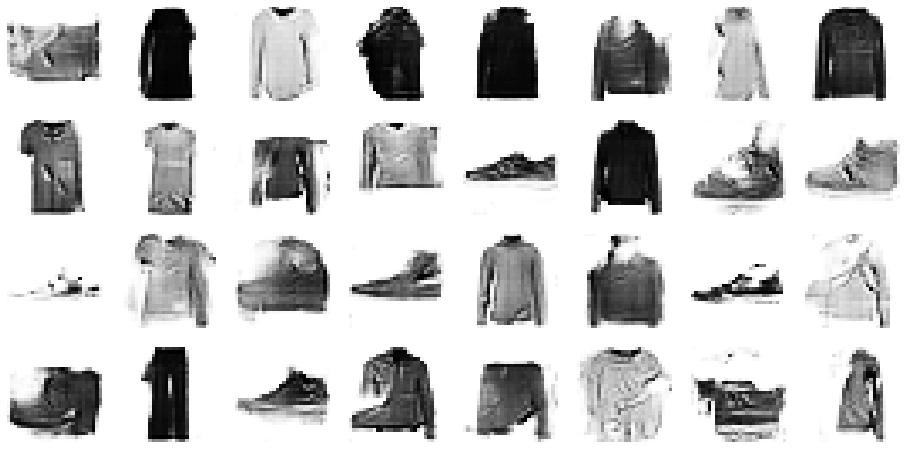

In [65]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8, scale_factor=2)

In [66]:
noise.shape

TensorShape([32, 100])

In [69]:
gan.save("model.h5")